# Problem 2 Sample Code

This sample code is meant as a guide on how to use PyTorch and how to use the relevant model layers. This not a guide on how to design a network and the network in this example is intentionally designed to have poor performace.

In [2]:
# import sys
# !{sys.executable} -m pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
    
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [3]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

0.1%

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


28.4%

0.5%5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [7]:
print(len(train_dataset), type(train_dataset[0][0]), type(train_dataset[0][1]))
print(len(test_dataset), type(test_dataset[0][0]), type(test_dataset[0][1]))
a = len(train_dataset[0])
b = len(train_dataset[0][0])
c = len(train_dataset[0][0][0])
print(a)
print(b)
print(c)

60000 <class 'torch.Tensor'> <class 'int'>
10000 <class 'torch.Tensor'> <class 'int'>
2
1
28


We can convert images to numpy arrays and plot them with matplotlib:

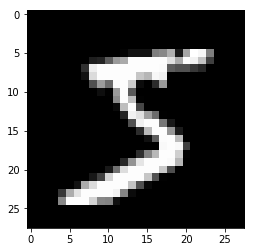

In [8]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Network Definition
Let's instantiate a model and take a look at the layers.

In [9]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 20),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(20, 10)
)
print(model)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=20, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=20, out_features=10, bias=True)
)


## Training
We also choose an optimizer and a loss function.

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

We could write our training procedure manually and directly index the `Dataset` objects, but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 

We now write our backpropagation loop, training for 10 epochs.

In [12]:
# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.4499
Train Epoch: 2  Loss: 0.6528
Train Epoch: 3  Loss: 0.5716
Train Epoch: 4  Loss: 0.5873
Train Epoch: 5  Loss: 0.5245
Train Epoch: 6  Loss: 0.4954
Train Epoch: 7  Loss: 0.5398
Train Epoch: 8  Loss: 0.7258
Train Epoch: 9  Loss: 0.5781
Train Epoch: 10  Loss: 0.3674


## Testing
We can perform forward passes through the network without saving gradients.

In [13]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0087, Accuracy: 9248/10000 (92.4800)


# Function for Training the Model

In [14]:
def train_model(model, batch_sz, num_epochs):
    # choose optimizer to be Adama and loss function to be Cross Entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sz, shuffle=True) 

    # Some layers, such as Dropout, behave differently during training
    model.train()

    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)

            # Backward pass
            loss.backward()

            # Weight update
            optimizer.step()

        # Track loss each epoch
        print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

    # Putting layers like Dropout into evaluation mode
    model.eval()

    test_loss = 0
    correct = 0

    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
          (test_loss, correct, len(test_loader.dataset),
           100. * correct / len(test_loader.dataset)))

# Problem 2C

In [15]:
model2c = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)
train_model(model2c, 32, 10)

Train Epoch: 1  Loss: 0.1016
Train Epoch: 2  Loss: 0.2973
Train Epoch: 3  Loss: 0.0365
Train Epoch: 4  Loss: 0.0383
Train Epoch: 5  Loss: 0.0363
Train Epoch: 6  Loss: 0.0180
Train Epoch: 7  Loss: 0.0165
Train Epoch: 8  Loss: 0.0367
Train Epoch: 9  Loss: 0.0220
Train Epoch: 10  Loss: 0.0022
Test set: Average loss: 0.0026, Accuracy: 9762/10000 (97.6200)


# Problem 2D

In [24]:
model2d = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 120),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(120, 80),
    nn.ReLU(),
    nn.Linear(80, 10)
    
)
train_model(model2d, 32, 10)

Train Epoch: 1  Loss: 0.1886
Train Epoch: 2  Loss: 0.3007
Train Epoch: 3  Loss: 0.1198
Train Epoch: 4  Loss: 0.0228
Train Epoch: 5  Loss: 0.0559
Train Epoch: 6  Loss: 0.4365
Train Epoch: 7  Loss: 0.2096
Train Epoch: 8  Loss: 0.0863
Train Epoch: 9  Loss: 0.1786
Train Epoch: 10  Loss: 0.0609
Test set: Average loss: 0.0022, Accuracy: 9812/10000 (98.1200)


# Problem 2E

In [34]:
model2e = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 700),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(700, 200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
)
train_model(model2d, 200, 10)

Train Epoch: 1  Loss: 0.0036
Train Epoch: 2  Loss: 0.0005
Train Epoch: 3  Loss: 0.0100
Train Epoch: 4  Loss: 0.0493
Train Epoch: 5  Loss: 0.0311
Train Epoch: 6  Loss: 0.0261
Train Epoch: 7  Loss: 0.0019
Train Epoch: 8  Loss: 0.0039
Train Epoch: 9  Loss: 0.0065
Train Epoch: 10  Loss: 0.0064
Test set: Average loss: 0.0006, Accuracy: 9832/10000 (98.3200)
